In [1]:
# pip install keras

In [2]:
# pip install tensorflow

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [4]:
df = pd.read_csv('model_modified.csv')
df.head()

,Date,Price
0,2014-01-01,38.21
1,2014-01-02,37.61
2,2014-01-03,37.01
3,2014-01-06,36.63
4,2014-01-07,35.41


In [5]:
df.tail()

,Date,Price
2556,2024-05-06,167.45
2557,2024-05-07,164.25
2558,2024-05-08,166.05
2559,2024-05-09,161.90
2560,2024-05-10,162.40


In [6]:
cop = df.reset_index()['Price']
cop

0        38.21
1        37.61
2        37.01
3        36.63
4        35.41
         ...  
2556    167.45
2557    164.25
2558    166.05
2559    161.90
2560    162.40
Name: Price, Length: 2561, dtype: float64

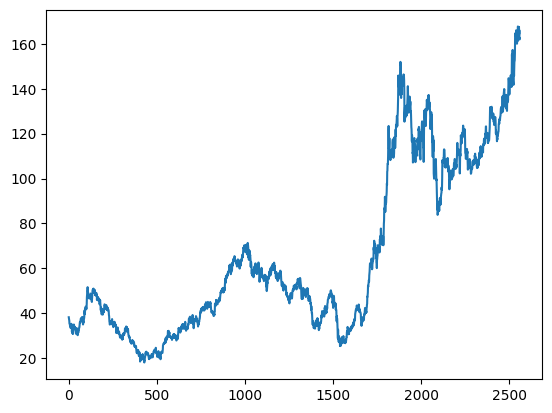

In [7]:
plt.plot(cop)

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
cop = scaler.fit_transform(np.array(cop).reshape(-1,1))

In [9]:
len(cop)

2561

In [10]:
trainingSize = int(len(cop)*0.80)
testSize = len(cop)-trainingSize

train_data, test_data = cop[0:trainingSize,:],cop[trainingSize:len(cop),:1]

In [11]:
len(train_data),len(test_data)

(2048, 513)

In [12]:
def create_data(data,time_step):
    X, y = [],[]
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step),0]
        b = data[i+time_step,0]
        X.append(a)
        y.append(b)

    return np.array(X), np.array(y)

In [13]:
time_step = 100
X_train, y_train = create_data(train_data,time_step)
X_test, y_test = create_data(test_data,time_step)

In [14]:
print(X_train.shape), print(X_test.shape)

(1947, 100)
(412, 100)


(None, None)

In [15]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

In [17]:
def buildModel(input_shape):
    input_layer = Input(shape=input_shape)
    model = LSTM(units=128,return_sequences=True)(input_layer)
    model = Dropout(0.2)(model)
    model = LSTM(units=128,return_sequences=True)(model)
    model = Dropout(0.2)(model)
    model = LSTM(units=128,return_sequences=False)(model)
    model = Dropout(0.2)(model)
    model = Dense(64,activation='relu')(model)
    model = Dropout(0.2)(model)
    model = Dense(64,activation='relu')(model)
    output_layer = Dense(1)(model)
    neuron = Model(inputs=input_layer,outputs=output_layer)
    neuron.compile(loss='mean_squared_error',optimizer='adam')
    return neuron

In [18]:
clf = buildModel((100,1))
clf.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 100, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 342,209 (1.31 MB)

 Trainable params: 342,209 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
hist = clf.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=64)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - loss: 0.0390 - val_loss: 0.0016
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - loss: 0.0021 - val_loss: 0.0057
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/ste

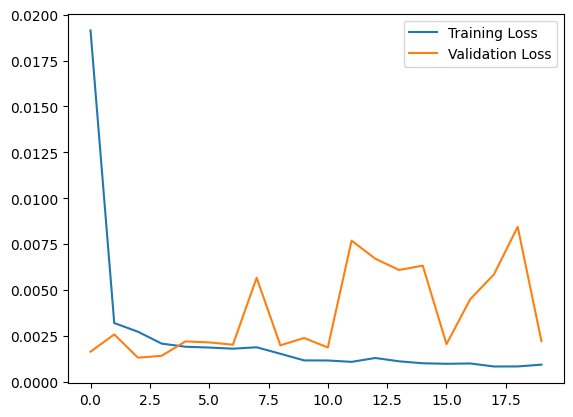

In [20]:
plt.plot(hist.history['loss'],label='Training Loss')
plt.plot(hist.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()

In [21]:
train_predict=clf.predict(X_train)
test_predict=clf.predict(X_test)

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [22]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [23]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

60.170136110846805

In [24]:
math.sqrt(mean_squared_error(y_test,test_predict))

117.16299641413283

In [25]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
mae = mean_absolute_error(y_train,train_predict)
maep = mean_absolute_percentage_error(y_train,train_predict)
print(mae,maep)

53.447424971591296 55808681511868.61


In [26]:
mae_pred = mean_absolute_error(y_test,test_predict)
maep_pred = mean_absolute_percentage_error(y_test,test_predict)
print(mae_pred,maep_pred)

116.44354791377302 169.638897895171


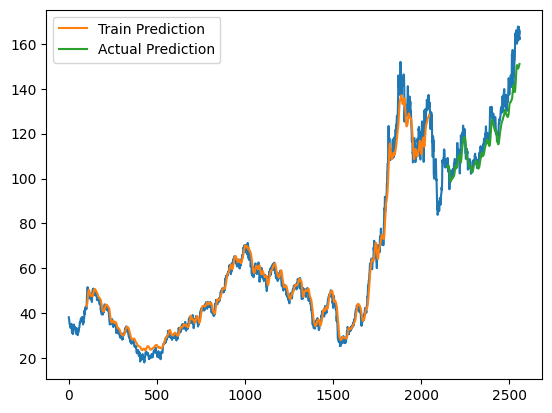

In [27]:
look_back=100
trainPredictPlot = np.empty_like(cop)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(cop)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(cop)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(cop))
plt.plot(trainPredictPlot,label='Train Prediction')
plt.plot(testPredictPlot, label='Actual Prediction')
plt.legend()
plt.show()


In [28]:
len(test_data)

513

In [29]:
x_input = test_data[413:].reshape(1,-1)
x_input.shape

(1, 100)

In [30]:
temp_in = list(x_input)
temp_in = temp_in[0].tolist()

In [31]:
temp_in

[0.7614114816547484,
 0.7911515070507251,
 0.7921539798168816,
 0.7841341976876296,
 0.7463743901624006,
 0.7547283298803716,
 0.7717703669050325,
 0.7827975673327541,
 0.7961638708815076,
 0.8025128650671658,
 0.812203435140012,
 0.8138742230836062,
 0.812203435140012,
 0.7838000400989107,
 0.7764485731470963,
 0.7724386820824701,
 0.7614114816547484,
 0.7724386820824701,
 0.7754461003809396,
 0.7807926218004412,
 0.7834658825101919,
 0.7807926218004412,
 0.7964980284702265,
 0.7590723785337166,
 0.7547283298803716,
 0.7764485731470963,
 0.7744436276147831,
 0.7487134932834325,
 0.7824634097440354,
 0.7731069972599078,
 0.7814609369778788,
 0.7794559914455657,
 0.7878099311635367,
 0.7801243066230035,
 0.8061885985430729,
 0.8252355811000469,
 0.8459533516006149,
 0.8442825636570207,
 0.8392701998262382,
 0.8235647931564527,
 0.7975005012363832,
 0.8005079195348527,
 0.8228964779790149,
 0.8228964779790149,
 0.8302479449308295,
 0.8279088418097975,
 0.8218940052128585,
 0.840940987769

In [32]:
lst_output=[]
n_steps=100
i=0
while(i<1):
    
    if(len(temp_in)>100):
        #print(temp_input)
        x_input=np.array(temp_in[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = clf.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_in.extend(yhat[0].tolist())
        temp_in=temp_in[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = clf.predict(x_input, verbose=0)
        print(yhat[0])
        temp_in.extend(yhat[0].tolist())
        print(len(temp_in))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.8876144]
101
[[0.8876144289970398]]


In [33]:
scaled_pred = scaler.inverse_transform(lst_output)
print(scaled_pred)

[[150.88374701]]


In [34]:
len(cop)

2561

In [35]:
day_new=np.arange(1,101)
day_pred=np.arange(101,102)

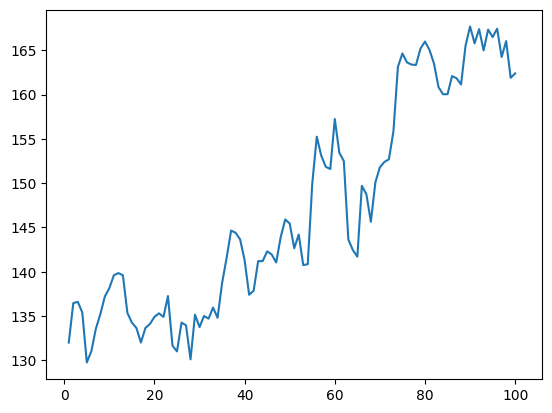

In [36]:
plt.plot(day_new,scaler.inverse_transform(cop[2461:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))